In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from google.colab import files
import time
import io

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/')

from mpdl3 import train_network, Flatten, View, weight_reset

In [0]:
!rm simple_net_2.pt

#Data Loading and Prep

In [0]:
%%timeit
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving UNSWdata.tar.gz to UNSWdata.tar.gz
User uploaded file "UNSWdata.tar.gz" with length 122706982 bytes


The slowest run took 17.69 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 32.4 s per loop


In [0]:
'''
UNSWdata.tar.gz contains 4 tar.gz files: UNSW-NB15_*.tar.gz where * is 1 through 4.
Each UNSW-NB15_*.tar.gz contains a corresponding .csv file.
This was necessary because the original files are roughly 750MB, so loading directly
from .csv into a dataframe takes about an hour. With the tar.gz compression, this process
is cut down to about 10 minutes.
'''

# Extract from master tar.gz file
import tarfile
tf = tarfile.open(name='UNSWdata.tar.gz')
tf.extractall()

In [0]:
# Extract csv files from each tar.gz file
for i in range(1,5):
  tf = tarfile.open(name='UNSW-NB15_'+str(i)+'.tar.gz')
  tf.extractall()

In [0]:
# Read csv files into one dataframe

temp_list = []

for i in range(1,5):
    filename = 'UNSW-NB15_'+str(i)+'.csv'
    df = pd.read_csv(filename, index_col=None, header=None)
    temp_list.append(df)

data = pd.concat(temp_list, axis=0, ignore_index=True)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,3,47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,39,47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving UNSW-NB15_features.csv to UNSW-NB15_features.csv
User uploaded file "UNSW-NB15_features.csv" with length 4044 bytes


In [0]:
# getting feature names

feature_list = pd.read_csv('UNSW-NB15_features.csv',encoding='unicode_escape')
column_names = list(feature_list.Name)
data.columns = column_names

In [0]:
data.shape # (2540047, 49)

(2540047, 49)

In [0]:
print('Number of total attacks:',data.Label.sum(),'out of 2540047') #Number of total attacks: 321283 out of 2540047
print('Percent attacks:',round(data.Label.mean(),2)*100,'%')        #Percent attacks: 13.0 %

Number of total attacks: 321283 out of 2540047
Percent attacks: 13.0 %


In [0]:
data.head()

,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,Sload,Dload,Spkts,Dpkts,swin,dwin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,Sjit,Djit,Stime,Ltime,Sintpkt,Dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,29,0,0,dns,500473.93750,621800.93750,2,2,0,0,0,0,66,82,0,0,0.00000,0.000000,1421927414,1421927414,0.017,0.013000,0.0,0.0,0.0,0,0,0.0,0.0,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,29,0,0,-,87676.08594,50480.17188,4,4,0,0,0,0,132,76,0,0,9.89101,10.682733,1421927414,1421927414,7.005,7.564333,0.0,0.0,0.0,0,0,0.0,0.0,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,29,0,0,dns,521894.53130,636282.37500,2,2,0,0,0,0,73,89,0,0,0.00000,0.000000,1421927414,1421927414,0.017,0.013000,0.0,0.0,0.0,0,0,0.0,0.0,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,29,0,0,dns,436724.56250,542597.18750,2,2,0,0,0,0,66,82,0,0,0.00000,0.000000,1421927414,1421927414,0.043,0.014000,0.0,0.0,0.0,0,0,0.0,0.0,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,29,0,0,dns,499572.25000,609067.56250,2,2,0,0,0,0,73,89,0,0,0.00000,0.000000,1421927414,1421927414,0.005,0.003000,0.0,0.0,0.0,0,0,0.0,0.0,0,7,9,1,1,1,1,1,NaN,0


In [0]:
data.attack_cat.unique()

array([nan, 'Exploits', 'Reconnaissance', 'DoS', 'Generic', 'Shellcode',
       ' Fuzzers', 'Worms', 'Backdoors', 'Analysis', ' Reconnaissance ',
       'Backdoor', ' Fuzzers ', ' Shellcode '], dtype=object)

In [0]:
replace_dict = {' Fuzzers':'Fuzzers',' Fuzzers ':'Fuzzers',' Reconnaissance ':'Reconnaissance',
                'Backdoors':'Backdoor', ' Shellcode ':'Shellcode'}

data.attack_cat = data.attack_cat.replace(replace_dict)

In [0]:
data.attack_cat.unique()

array([nan, 'Exploits', 'Reconnaissance', 'DoS', 'Generic', 'Shellcode',
       'Fuzzers', 'Worms', 'Backdoor', 'Analysis'], dtype=object)

In [0]:
values={'attack_cat':'Normal'}
data.fillna(value=values,inplace=True) #NaNs in attack_cat is normal traffic
attack_dict = {k: v for v, k in enumerate(list(data.attack_cat.unique()))}  #encode each unique attack type with a value
data['attack_value'] = data['attack_cat'].map(attack_dict) 


In [0]:
attack_data = data[data['attack_cat'] != 'Normal']

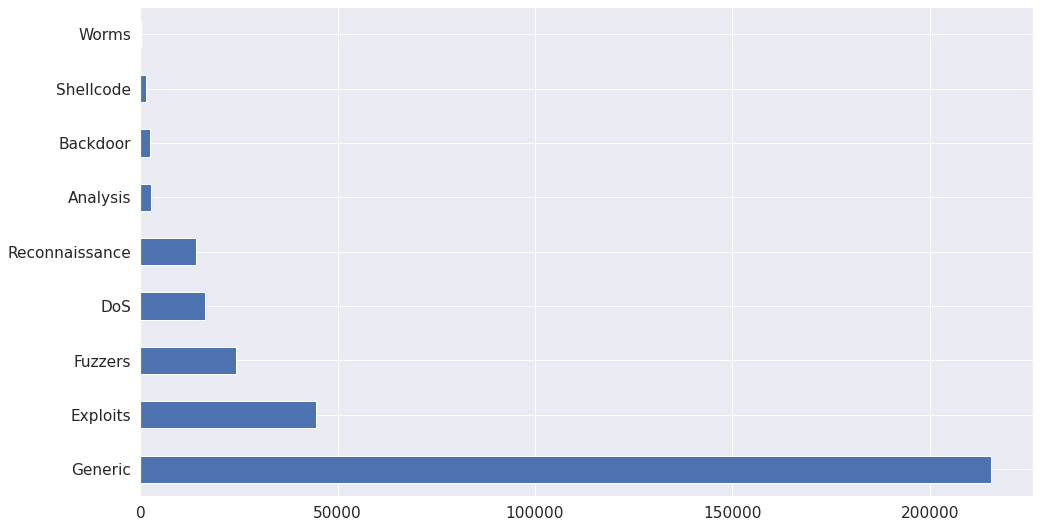

In [0]:
plt.figure(figsize=(16,9))
attack_data.attack_cat.value_counts().plot.barh()
#plt.savefig('attack_counts.png',format='png')
#files.download('attack_counts.png')

In [0]:

#Drop unnecessary columns
data = data.drop(['srcip','sport','dstip','dsport','proto','service','state','Stime','Ltime'],axis=1)
data.columns = data.columns.str.lower()
data.attack_cat.nunique()

In [0]:
attack_dict

{'Analysis': 9,
 'Backdoor': 8,
 'DoS': 3,
 'Exploits': 1,
 'Fuzzers': 6,
 'Generic': 4,
 'Normal': 0,
 'Reconnaissance': 2,
 'Shellcode': 5,
 'Worms': 7}

Cleaning the larger dataset has revealed two NaN heavy columns, 'ct_flw_http_mthd' and 'is_ftp_login'.  
**'is_ftp_login'** is supposed to be a binary that indicates whether the packets come from a user with an ftp login. However, there are a large amount of NaNs. There are also some values outside of 0 and 1 that aren't NaN, but there are a small amount of them.  
**'ct_flw_http_mthd'** according to the documentation:  
"*No. of flows that has methods such as Get and Post in http service.*"

In [0]:
nan_values = data.isna()
nan_columns = nan_values.any()

columns_with_nan = data.columns[nan_columns].tolist()
print(columns_with_nan)

['ct_flw_http_mthd', 'is_ftp_login']


In [0]:
data.is_ftp_login = data.is_ftp_login.fillna(value=100)
data.ct_flw_http_mthd = data.ct_flw_http_mthd.fillna(value=100)

In [0]:
data = data.drop(labels=['attack_cat','ct_ftp_cmd'],axis=1)
data = data.astype('float64')
data['label'] = data['label'].astype('int64')
data['attack_value'] = data['attack_value'].astype('int64')

In [0]:
data.dtypes

dur                 float64
sbytes              float64
dbytes              float64
sttl                float64
dttl                float64
sloss               float64
dloss               float64
sload               float64
dload               float64
spkts               float64
dpkts               float64
swin                float64
dwin                float64
stcpb               float64
dtcpb               float64
smeansz             float64
dmeansz             float64
trans_depth         float64
res_bdy_len         float64
sjit                float64
djit                float64
sintpkt             float64
dintpkt             float64
tcprtt              float64
synack              float64
ackdat              float64
is_sm_ips_ports     float64
ct_state_ttl        float64
ct_flw_http_mthd    float64
is_ftp_login        float64
ct_srv_src          float64
ct_srv_dst          float64
ct_dst_ltm          float64
ct_src_ ltm         float64
ct_src_dport_ltm    float64
ct_dst_sport_ltm    

In [0]:
data.shape

(2540047, 39)

In [0]:
data.head()

,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,sload,dload,spkts,dpkts,swin,dwin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,sjit,djit,sintpkt,dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,label,attack_value
0,0.001055,132.0,164.0,31.0,29.0,0.0,0.0,500473.93750,621800.93750,2.0,2.0,0.0,0.0,0.0,0.0,66.0,82.0,0.0,0.0,0.00000,0.000000,0.017,0.013000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,7.0,1.0,3.0,1.0,1.0,1.0,0,0
1,0.036133,528.0,304.0,31.0,29.0,0.0,0.0,87676.08594,50480.17188,4.0,4.0,0.0,0.0,0.0,0.0,132.0,76.0,0.0,0.0,9.89101,10.682733,7.005,7.564333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,2.0,3.0,1.0,1.0,2.0,0,0
2,0.001119,146.0,178.0,31.0,29.0,0.0,0.0,521894.53130,636282.37500,2.0,2.0,0.0,0.0,0.0,0.0,73.0,89.0,0.0,0.0,0.00000,0.000000,0.017,0.013000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,8.0,1.0,2.0,2.0,1.0,1.0,0,0
3,0.001209,132.0,164.0,31.0,29.0,0.0,0.0,436724.56250,542597.18750,2.0,2.0,0.0,0.0,0.0,0.0,66.0,82.0,0.0,0.0,0.00000,0.000000,0.043,0.014000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,9.0,1.0,1.0,1.0,1.0,1.0,0,0
4,0.001169,146.0,178.0,31.0,29.0,0.0,0.0,499572.25000,609067.56250,2.0,2.0,0.0,0.0,0.0,0.0,73.0,89.0,0.0,0.0,0.00000,0.000000,0.005,0.003000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,9.0,1.0,1.0,1.0,1.0,1.0,0,0


#Neural Network Prep

In [0]:
data_X = data.iloc[:, 0:-2]
data_X.head()

,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,sload,dload,spkts,dpkts,swin,dwin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,sjit,djit,sintpkt,dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm
0,0.001055,132.0,164.0,31.0,29.0,0.0,0.0,500473.93750,621800.93750,2.0,2.0,0.0,0.0,0.0,0.0,66.0,82.0,0.0,0.0,0.00000,0.000000,0.017,0.013000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,7.0,1.0,3.0,1.0,1.0,1.0
1,0.036133,528.0,304.0,31.0,29.0,0.0,0.0,87676.08594,50480.17188,4.0,4.0,0.0,0.0,0.0,0.0,132.0,76.0,0.0,0.0,9.89101,10.682733,7.005,7.564333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,2.0,3.0,1.0,1.0,2.0
2,0.001119,146.0,178.0,31.0,29.0,0.0,0.0,521894.53130,636282.37500,2.0,2.0,0.0,0.0,0.0,0.0,73.0,89.0,0.0,0.0,0.00000,0.000000,0.017,0.013000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,8.0,1.0,2.0,2.0,1.0,1.0
3,0.001209,132.0,164.0,31.0,29.0,0.0,0.0,436724.56250,542597.18750,2.0,2.0,0.0,0.0,0.0,0.0,66.0,82.0,0.0,0.0,0.00000,0.000000,0.043,0.014000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,9.0,1.0,1.0,1.0,1.0,1.0
4,0.001169,146.0,178.0,31.0,29.0,0.0,0.0,499572.25000,609067.56250,2.0,2.0,0.0,0.0,0.0,0.0,73.0,89.0,0.0,0.0,0.00000,0.000000,0.005,0.003000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,9.0,1.0,1.0,1.0,1.0,1.0


In [0]:
data_y = data.iloc[:, -1]
data_y.head()

0    0
1    0
2    0
3    0
4    0
Name: attack_value, dtype: int64

In [0]:
# Split data into training + test sets, and validation set
X_traintest, X_val, y_traintest, y_val = train_test_split(data_X, data_y, test_size=0.2, stratify=data_y, random_state=4)

# Split the combined training+test into training and test
X_train, X_test, y_train, y_test = train_test_split(X_traintest, y_traintest, test_size=0.2, stratify=y_traintest, random_state=44)

In [0]:
#Normalize data

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

#convert to Numpy arrays

X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [0]:
class unswData_multi(Dataset):
      def __init__(self, data_X, data_y):
          self.features = data_X
          self.labels = data_y
      
      def __getitem__(self, index):
          return torch.tensor(self.features[index,:],dtype=torch.float), torch.tensor(self.labels[index],dtype=torch.long)
      
      def __len__(self):
          return self.features.shape[0]

In [0]:
train_dataset = unswData_multi(X_train, y_train)
test_dataset = unswData_multi(X_test, y_test)
val_dataset = unswData_multi(X_val, y_val)

Weighted Resampling. 

See this article for an example of weighted resampling: https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab

Some of the code in this presentation was adapted from the above article.

In [0]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

In [0]:
class_list, class_count = np.unique(y_train, return_counts=True)

In [0]:
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)

tensor([7.0422e-07, 3.5093e-05, 1.1172e-04, 9.5547e-05, 7.2512e-06, 1.0341e-03,
        6.4441e-05, 9.0090e-03, 6.7114e-04, 5.8343e-04])


In [0]:
class_weights_all = class_weights[target_list]

In [0]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [0]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [0]:
train_load = DataLoader(dataset=train_dataset,
                          batch_size=128,
                          sampler=weighted_sampler
)
val_load = DataLoader(dataset=val_dataset, batch_size=128)
test_load = DataLoader(dataset=test_dataset, batch_size=128)

#Neural Net model

In [0]:
#How many values are in the input? We use this to help determine the size of subsequent layers
D = 37
#Hidden layer size
n = 15 
#How many classes are there?
classes = 10

loss_func = nn.CrossEntropyLoss(weight=class_weights.to(device))

In [0]:
simple_model = nn.Sequential(
    nn.Linear(D,  n),
    nn.BatchNorm1d(n),
    nn.LeakyReLU(),
    nn.Linear(n,  n),
    nn.BatchNorm1d(n),
    nn.LeakyReLU(),
    nn.Linear(n,  n),
    nn.BatchNorm1d(n),
    nn.LeakyReLU(),
    nn.Linear(n,  n),
    nn.BatchNorm1d(n),
    nn.LeakyReLU(),
    nn.Linear(n, classes),
)

In [0]:
simple_model_100 = train_network(simple_model,loss_func=loss_func,train_loader=train_load,val_loader=test_load,
                               score_funcs = {'Accuracy:':accuracy_score},epochs=100,device=device,
                               optimizer = torch.optim.AdamW(simple_model.parameters(), lr=0.001), checkpoint_file='simple_net_2.pt')

In [0]:
files.download('simple_net_2.pt')

In [0]:
simple_model_100

,epoch,total time,train loss,val loss,train Accuracy:,val Accuracy:
0,0,76.556464,1.611514e+06,1.611514e+06,0.940695,0.963426
1,1,151.709041,1.294553e+06,1.294553e+06,0.964598,0.964031
2,2,227.637686,1.223004e+06,1.223004e+06,0.964918,0.964071
3,3,301.809934,1.184428e+06,1.184428e+06,0.965966,0.966000
4,4,376.976490,1.161508e+06,1.161508e+06,0.966190,0.966012
...,...,...,...,...,...,...
95,95,7142.564111,1.036819e+06,1.036819e+06,0.969178,0.967737
96,96,7216.075096,1.036725e+06,1.036725e+06,0.969301,0.968305
97,97,7289.359584,1.016833e+06,1.016833e+06,0.969688,0.966354
98,98,7364.305604,1.031481e+06,1.031481e+06,0.969732,0.968015


In [0]:
def evaluation(model, val_load):
  model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!
  model = model.to(device)
  y_true = []
  y_pred = []
  results = []
  running_loss = 0.0


  for inputs, labels in val_load:
          
    #Move the batch to the device we are using. 
    inputs = inputs.to(device)
    labels = labels.to(device)
          
    batch_size = inputs.shape[0]
    y_hat = model(inputs)
              
    loss = nn.CrossEntropyLoss()(y_hat, labels)
                  
    #Now we are just grabbing some information we would like to have
    running_loss += loss.item() * inputs.size(0)

    #moving labels & predictions back to CPU for computing / storing predictions
    labels = labels.detach().cpu().numpy()
    y_hat = y_hat.detach().cpu().numpy()
    for i in range(batch_size):
        y_true.append(labels[i])
        y_pred.append(y_hat[i,:])
            
    results.append( running_loss )

  accuracy = np.sum(np.array(y_true) == np.argmax(np.array(y_pred), axis=1))/float(len(y_true))
  cm = confusion_matrix(np.array(y_true), np.argmax(np.array(y_pred), axis=1))
  df_cm = pd.DataFrame(cm)
  return accuracy, df_cm

In [0]:
simple_acc, simple_cm = evaluation(simple_model, val_load)

In [0]:
simple_acc

0.9671187575047735

In [0]:
simple_cm

,0,1,2,3,4,5,6,7,8,9
0,437397,356,458,57,56,64,4673,3,4,685
1,6,4905,427,1556,7,117,435,6,147,1299
2,0,321,1939,223,1,86,105,1,10,112
3,2,701,187,1306,5,38,136,3,100,793
4,3,551,69,264,41724,47,268,3,15,152
5,0,20,110,13,0,112,43,0,2,2
6,1,245,286,298,18,60,3614,4,54,269
7,0,27,0,0,0,1,3,4,0,0
8,0,59,59,136,1,9,27,0,26,149
9,0,44,18,158,0,1,15,0,20,279


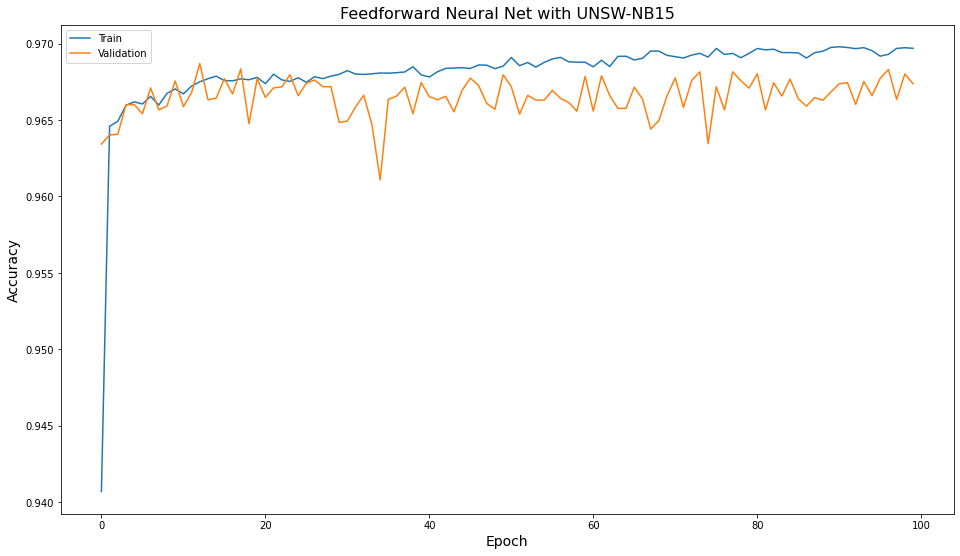

In [0]:
plt.figure(figsize=(16,9))
sns.lineplot(x='epoch',y='train Accuracy:', data=simple_model_100, label='Train')
sns.lineplot(x='epoch',y='val Accuracy:', data=simple_model_100, label='Validation')
plt.xlabel('Epoch', size=14)
plt.ylabel('Accuracy', size=14)
plt.title('Feedforward Neural Net with UNSW-NB15', size=16)
#plt.savefig('simple_net_2.png',format='png')
#files.download('simple_net_2.png')

In [0]:
checkpoint_dict = torch.load('simple_net_2.pt', map_location=device)

In [0]:
load_simple_model = nn.Sequential(
    nn.Linear(D,  n),
    nn.BatchNorm1d(n),
    nn.LeakyReLU(),
    nn.Linear(n,  n),
    nn.BatchNorm1d(n),
    nn.LeakyReLU(),
    nn.Linear(n,  n),
    nn.BatchNorm1d(n),
    nn.LeakyReLU(),
    nn.Linear(n,  n),
    nn.BatchNorm1d(n),
    nn.LeakyReLU(),
    nn.Linear(n, classes),
)

In [0]:
load_simple_model.load_state_dict(checkpoint_dict['model_state_dict'])

<All keys matched successfully>

In [0]:
simple_model_300 = train_network(load_simple_model,loss_func=loss_func,train_loader=train_load,val_loader=test_load,
                               score_funcs = {'Accuracy:':accuracy_score},epochs=200,device=device,
                               optimizer = torch.optim.AdamW(load_simple_model.parameters(), lr=0.001), checkpoint_file='simple_net_300.pt')

In [0]:
simple_acc, simple_cm = evaluation(load_simple_model, val_load)

In [0]:
simple_acc

0.9662920021259424

In [0]:
simple_cm

,0,1,2,3,4,5,6,7,8,9
0,437001,343,274,97,42,81,5247,0,43,625
1,5,4126,455,2253,2,277,714,5,104,964
2,0,86,2026,301,1,90,156,0,48,90
3,0,476,91,1730,4,125,200,0,56,589
4,1,493,48,290,41727,57,364,5,12,99
5,0,4,99,10,0,129,48,0,10,2
6,0,89,150,310,16,90,3857,1,62,274
7,0,27,0,0,0,2,5,0,0,1
8,0,29,20,180,1,28,27,0,36,145
9,0,19,5,221,0,7,8,0,21,254


In [0]:
simple_model_300

,epoch,total time,train loss,val loss,train Accuracy:,val Accuracy:
0,0,80.983392,1.269649e+06,1.269649e+06,0.971885,0.966863
1,1,161.969576,1.210873e+06,1.210873e+06,0.971748,0.966275
2,2,243.934805,1.170625e+06,1.170625e+06,0.972186,0.967004
3,3,325.499694,1.166369e+06,1.166369e+06,0.971808,0.966962
4,4,407.556554,1.169128e+06,1.169128e+06,0.972506,0.966509
...,...,...,...,...,...,...
195,195,14990.539637,1.106945e+06,1.106945e+06,0.972363,0.964993
196,196,15064.617811,1.096812e+06,1.096812e+06,0.972592,0.967570
197,197,15138.501544,1.087441e+06,1.087441e+06,0.972916,0.965682
198,198,15212.541348,1.096814e+06,1.096814e+06,0.972499,0.967284


In [0]:
files.download('simple_net_300.pt')

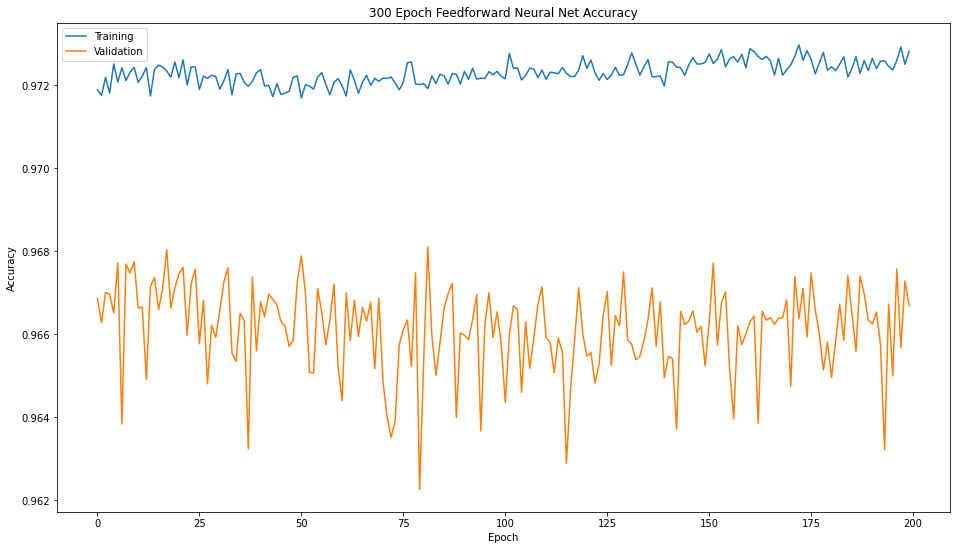

In [0]:
plt.figure(figsize=(16,9))
sns.lineplot(x='epoch',y='train Accuracy:',data=simple_model_300,label='Training')
sns.lineplot(x='epoch',y='val Accuracy:',data=simple_model_300, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('300 Epoch Feedforward Neural Net Accuracy')
#plt.savefig('simple_net_300_results.png',format='png')
#files.download('simple_net_300_results.png')

In [0]:
checkpoint_dict.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'results'])

In [0]:
model_results = pd.DataFrame(checkpoint_dict['results'])

In [0]:
model_results

,epoch,total time,train loss,val loss,train Accuracy:,val Accuracy:
0,0,76.556464,1.611514e+06,1.611514e+06,0.940695,0.963426
1,1,151.709041,1.294553e+06,1.294553e+06,0.964598,0.964031
2,2,227.637686,1.223004e+06,1.223004e+06,0.964918,0.964071
3,3,301.809934,1.184428e+06,1.184428e+06,0.965966,0.966000
4,4,376.976490,1.161508e+06,1.161508e+06,0.966190,0.966012
...,...,...,...,...,...,...
95,95,7142.564111,1.036819e+06,1.036819e+06,0.969178,0.967737
96,96,7216.075096,1.036725e+06,1.036725e+06,0.969301,0.968305
97,97,7289.359584,1.016833e+06,1.016833e+06,0.969688,0.966354
98,98,7364.305604,1.031481e+06,1.031481e+06,0.969732,0.968015


The model was trained over two different batches. Here is the combination of the first 100 epochs with the second 200 epochs.

In [0]:
simple_model_300['epoch'] = simple_model_300['epoch'] + 100

In [0]:
combined = pd.concat([model_results, simple_model_300])

In [0]:
combined.columns

Index(['epoch', 'total time', 'train loss', 'val loss', 'train Accuracy:',
       'val Accuracy:'],
      dtype='object')

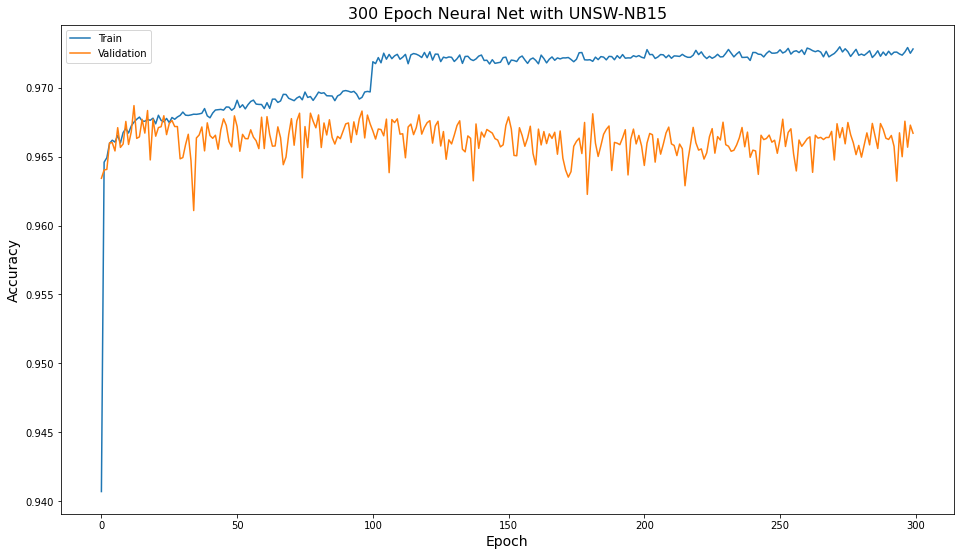

In [0]:
plt.figure(figsize=(16,9))
sns.lineplot(x='epoch',y='train Accuracy:', data=combined, label='Train')
sns.lineplot(x='epoch',y='val Accuracy:', data=combined, label='Validation')
plt.xlabel('Epoch', size=14)
plt.ylabel('Accuracy', size=14)
plt.title('300 Epoch Neural Net with UNSW-NB15', size=16)
#plt.savefig('results_300_epoch.png',format='png')
#files.download('results_300_epoch.png')